In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning - recurrent  Neural Network

Exemplo da AULA - SÉRIES TEMPORAIS - Prof. Jerônymo Marcondes Pinto <br>
AULA MINISTRADA EM R E TRADUZIDA PARA PYTHON COMO FORMA DE APRENDIZADO.

## Objetivo

Prever o preço das ações PETR4

y(t) = f(y(t-1))

In [3]:
df = pd.read_csv(r'bases\PETR4.SA.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-14,29.170000,29.670000,28.719999,29.450001,23.936726,50745400
1,2021-01-15,29.049999,29.080000,28.030001,28.120001,22.855711,80673300
2,2021-01-18,28.309999,28.850000,28.010000,28.070000,22.815071,68855700
3,2021-01-19,28.480000,28.860001,27.639999,28.690001,23.319004,61656000
4,2021-01-20,28.950001,29.120001,28.110001,28.209999,22.928862,60306200
...,...,...,...,...,...,...,...
244,2022-01-10,27.990000,28.240000,27.719999,28.010000,28.010000,37455200
245,2022-01-11,28.100000,29.070000,27.850000,28.990000,28.990000,62315600
246,2022-01-12,28.950001,29.910000,28.950001,29.719999,29.719999,81378200
247,2022-01-13,29.530001,30.629999,29.500000,30.320000,30.320000,76717500


## Tratando a base para o Modelo RNN

Prever o valor da ação no fechamento baseado no valor do fechamento anterior

fechmaneto = f(fechamento_anterior)

In [10]:
df_analise = pd.DataFrame()
df_analise['Fechamento'] = df['Close']
df_analise['Fechamento_Anterior'] = df['Close'].shift(-1)
df_analise = df_analise.dropna()
df_analise

,Fechamento,Fechamento_Anterior
0,29.450001,28.120001
1,28.120001,28.070000
2,28.070000,28.690001
3,28.690001,28.209999
4,28.209999,27.549999
...,...,...
243,28.180000,28.010000
244,28.010000,28.990000
245,28.990000,29.719999
246,29.719999,30.320000


In [12]:
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_analise['X_std'] = scaler.fit_transform(df_analise['Fechamento_Anterior'].values.reshape(-1,1))
df_analise['y_std'] = scaler.fit_transform(df_analise['Fechamento'].values.reshape(-1,1))
df_analise

,Fechamento,Fechamento_Anterior,X_std,y_std
0,29.450001,28.120001,0.758099,0.905640
1,28.120001,28.070000,0.752700,0.761388
2,28.070000,28.690001,0.819654,0.755965
3,28.690001,28.209999,0.767818,0.823211
4,28.209999,27.549999,0.696544,0.771150
...,...,...,...,...
243,28.180000,28.010000,0.746220,0.767896
244,28.010000,28.990000,0.852052,0.749458
245,28.990000,29.719999,0.930885,0.855748
246,29.719999,30.320000,0.995680,0.934924


### Transforma os Dados em uma Matriz 31x8

A ideia é enviar várias amostras diversas vezes para manter a recorrência na rede. <br>
Para aprender conforme as amostras vão passando.

A base precisa ter 3 Dimensões

- 1- Quantidade de vezes que irá passar a amostra
- 2- Amostras
- 3- Número de features

In [13]:
X = df_analise['X_std'].values.reshape(8,31,1)
y = df_analise['y_std'].values.reshape(8,31,1)

In [15]:
# Train Test Split Manual
X_train = X[:6,:]
X_test = X[6:,:]

y_train = y[:6,:]
y_test = y[6:,:]

In [17]:
len(X_train), len(X_test)

(6, 2)

## Aplicando Modelo RNN

Documentação: https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN

In [247]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM
from tensorflow.keras.utils import set_random_seed

In [424]:
set_random_seed(12)
from keras.optimizers import Adam
adam_lr = Adam(learning_rate=0.005)

# Camada RNN
model = Sequential()
model.add(SimpleRNN(units=15, activation='tanh', return_sequences=True))

#Adicionar camadas intermediárias RNN (total de 18 camadas)
for _ in range(20):
    model.add(SimpleRNN(units=15, activation='relu', return_sequences=True))

# Última camada Escondida
model.add(SimpleRNN(units=15, activation='relu', return_sequences=False))

# Camada de saída
model.add(Dense(units=31, activation='tanh',)) # saída 31 pois temos 31 observações em cada sequência 

model.compile(optimizer=adam_lr, loss='mean_squared_error')

In [425]:
history = model.fit(X_train, y_train, epochs=200, batch_size=31)

Epoch 1/200
1/1 [==============================] - 14s 14s/step - loss: 0.3711
Epoch 2/200
1/1 [==============================] - 0s 85ms/step - loss: 0.6100
Epoch 3/200
1/1 [==============================] - 0s 86ms/step - loss: 0.3370
Epoch 4/200
1/1 [==============================] - 0s 80ms/step - loss: 0.3429
Epoch 5/200
1/1 [==============================] - 0s 82ms/step - loss: 0.3242
Epoch 6/200
1/1 [==============================] - 0s 81ms/step - loss: 0.3104
Epoch 7/200
1/1 [==============================] - 0s 81ms/step - loss: 0.2952
Epoch 8/200
1/1 [==============================] - 0s 81ms/step - loss: 0.2826
Epoch 9/200
1/1 [==============================] - 0s 80ms/step - loss: 0.2701
Epoch 10/200
1/1 [==============================] - 0s 80ms/step - loss: 0.2537
Epoch 11/200
1/1 [==============================] - 0s 81ms/step - loss: 0.2390
Epoch 12/200
1/1 [==============================] - 0s 83ms/step - loss: 0.2327
Epoch 13/200
1/1 [==============================]

1/1 [==============================] - 0s 81ms/step - loss: 0.0097
Epoch 104/200
1/1 [==============================] - 0s 80ms/step - loss: 0.0097
Epoch 105/200
1/1 [==============================] - 0s 81ms/step - loss: 0.0094
Epoch 106/200
1/1 [==============================] - 0s 81ms/step - loss: 0.0094
Epoch 107/200
1/1 [==============================] - 0s 81ms/step - loss: 0.0096
Epoch 108/200
1/1 [==============================] - 0s 81ms/step - loss: 0.0093
Epoch 109/200
1/1 [==============================] - 0s 81ms/step - loss: 0.0088
Epoch 110/200
1/1 [==============================] - 0s 81ms/step - loss: 0.0080
Epoch 111/200
1/1 [==============================] - 0s 80ms/step - loss: 0.0076
Epoch 112/200
1/1 [==============================] - 0s 80ms/step - loss: 0.0075
Epoch 113/200
1/1 [==============================] - 0s 81ms/step - loss: 0.0070
Epoch 114/200
1/1 [==============================] - 0s 81ms/step - loss: 0.0068
Epoch 115/200
1/1 [=======================

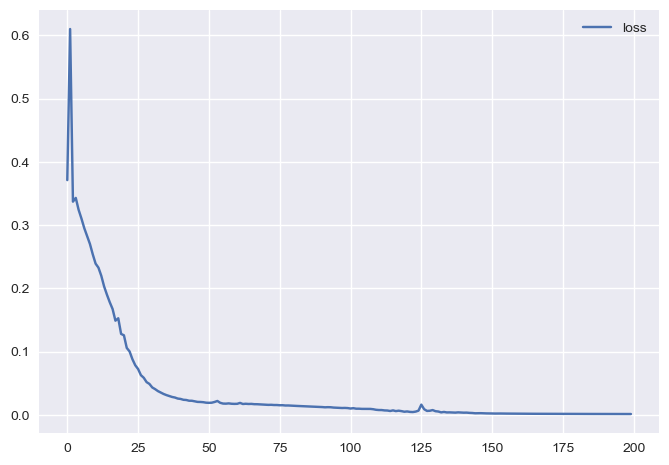

In [426]:
history_df = pd.DataFrame(history.history)
history_df.plot();

## R2 Modelo de Treino

In [427]:
y_hat_train = model.predict(X_train)

1/1 [==============================] - 2s 2s/step


In [428]:
y_hat_train.shape

(6, 31)

In [429]:
def indicadores (df, y, y_hat):
    n = len(df)
    SQE = sum((y - y_hat)**2)
    QME = SQE/n
    
    SST = sum((y - y.mean())**2)
    QMT = SST/n
    
    R2 = 1-SQE/SST

    print(f'R2: {R2}')

In [430]:
result = pd.DataFrame()
result['y_train'] = y_train.reshape(186)
result['y_hat_train'] = y_hat_train.reshape(186)
result

,y_train,y_hat_train
0,0.905640,0.826332
1,0.761388,0.755144
2,0.755965,0.757386
3,0.823211,0.794434
4,0.771150,0.774408
...,...,...
181,0.817787,0.825883
182,0.813449,0.821025
183,0.869848,0.832189
184,0.891540,0.894559


In [431]:
indicadores(result, result['y_train'], result['y_hat_train'])

R2: 0.9785433691289793


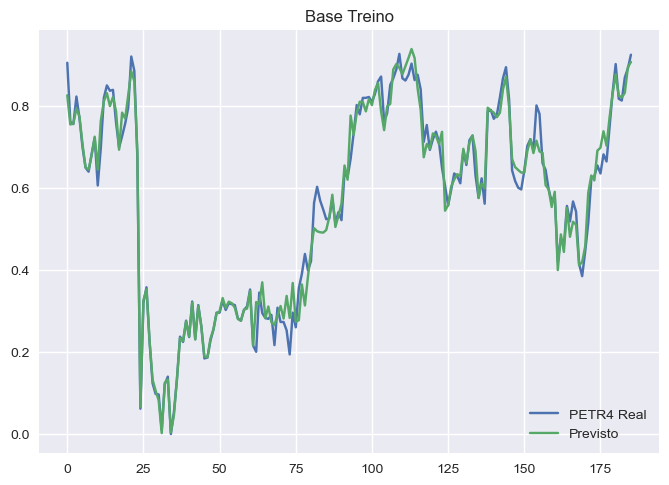

In [432]:
plt.title('Base Treino')
plt.style.use('seaborn')
plt.plot('y_train' ,data=result, label = 'PETR4 Real')
plt.plot('y_hat_train' ,data=result, label = 'Previsto')
plt.legend()

## Prevendo Modelo teste

In [433]:
y_hat_test = model.predict(X_test)

1/1 [==============================] - 0s 39ms/step


In [434]:
y_test.shape, y_hat_test.shape

((2, 31, 1), (2, 31))

In [435]:
result_test = pd.DataFrame()
result_test['y_test'] = y_test.reshape(62)
result_test['y_hat'] = y_hat_test.reshape(62)
result_test

,y_test,y_hat
0,0.930586,0.786539
1,0.921909,0.730155
2,0.905640,0.784370
3,0.749458,0.811745
4,0.802603,0.810555
...,...,...
57,0.767896,0.716327
58,0.749458,0.740449
59,0.855748,0.716823
60,0.934924,0.702246


In [436]:
indicadores(result_test, result_test['y_test'], result_test['y_hat'])

R2: -0.6926493105859854


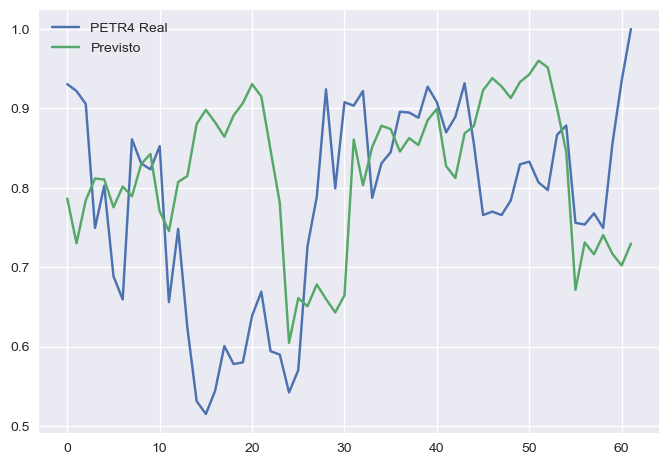

In [437]:
plt.style.use('seaborn')
plt.plot('y_test' ,data=result_test, label = 'PETR4 Real')
plt.plot('y_hat' ,data=result_test, label = 'Previsto')
plt.legend()

O medelo está com Overfiting, precisamos melhorá-lo através da alteração dos hyperparâmetros, tratamento da base, inclusão de mais legs (y(t-2)...)